# Treemap Visualization Example

This notebook demonstrates a treemap-style visualization using dartwork-mpl.

In [176]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import dartwork_mpl as dm

dm.style.use_preset("scientific")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
def text_color(fill):
    """
    Determine text color (black or white) based on background luminance.

    Parameters
    ----------
    fill : str
        Color name or hex code.

    Returns
    -------
    str
        'black' for light backgrounds, 'white' for dark backgrounds.
    """
    r, g, b = mcolors.to_rgb(fill)
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.6 else "white"

In [178]:
# Data: product category (category name and value) - adjusted to total 100
product_data = [
    ("Electronics", 34, "tw.blue:800"),
    ("Clothing", 21, "tw.blue:400"),
    ("Food", 16, "tw.blue:500"),
    ("Books", 15, "tw.cyan:500"),
    ("Toys", 6, "tw.teal:700"),
    ("Sports", 4, "tw.blue:600"),
    ("Home", 4, "tw.teal:400"),
]

# Data: region (category name and value) - adjusted to total 100
region_data = [
    ("North", 66, "tw.blue:800"),
    ("South", 15, "tw.blue:500"),
    ("East", 10, "tw.blue:400"),
    ("West", 5, "tw.cyan:600"),
    ("Central", 4, "tw.teal:400"),
]

# Calculate totals
product_total = sum(value for _, value, _ in product_data)
region_total = sum(value for _, value, _ in region_data)
print(f"Product total: {product_total}")
print(f"Region total: {region_total}")

Product total: 100
Region total: 100


In [179]:
# Organize product data into columns
# Column 1: Electronics (single large block)
# Column 2: Clothing, Books (stacked)
# Column 3: Food, Toys, Sports, Home (stacked)
product_columns = [
    [product_data[0]],  # Electronics
    [product_data[1], product_data[3]],  # Clothing, Books
    [
        product_data[2],
        product_data[4],
        product_data[5],
        product_data[6],
    ],  # Food, Toys, Sports, Home
]

# Organize region data into columns
# Column 1: North (single large block)
# Column 2: South, East, West, Central (stacked)
region_columns = [
    [region_data[0]],  # North
    [
        region_data[1],
        region_data[2],
        region_data[3],
        region_data[4],
    ],  # South, East, West, Central
]

# Calculate total value for each column
product_column_totals = [sum(value for _, value, _ in col) for col in product_columns]
region_column_totals = [sum(value for _, value, _ in col) for col in region_columns]
print(f"Product column totals: {product_column_totals}")
print(f"Region column totals: {region_column_totals}")

Product column totals: [34, 36, 30]
Region column totals: [66, 34]


In [180]:
def draw_treemap(ax, columns, column_totals, total, title):
    """
    Draw a treemap on the given axis.

    The area of each block is strictly proportional to its value.
    Block area = (block value / total) × total area

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on
    columns : list
        List of column data, each column is a list of (name, value, color) tuples
    column_totals : list
        Total value for each column
    total : int
        Total value for the entire treemap
    title : str
        Title for the treemap
    """
    ncols = len(columns)
    col_spacing = 0.0  # No spacing between columns
    block_spacing = 0.0  # No spacing between blocks

    # Total area is normalized to 1.0 (width × height = 1.0)
    total_area = 1.0
    col_height = 1.0  # All columns have same height

    # Calculate column widths (proportional to column totals)
    # Column width = (column total / total) × total width
    total_all = sum(column_totals)
    col_widths = [
        w / total_all * (1.0 - (ncols - 1) * col_spacing) for w in column_totals
    ]

    # Verification: store block areas for validation
    block_areas = []
    block_values = []

    # Draw blocks for each column
    x_start = 0.0
    for col_idx, col_data in enumerate(columns):
        col_width = col_widths[col_idx]

        # Calculate block heights within this column (proportional to values)
        # Block height = (block value / column total) × column height
        col_total = sum(value for _, value, _ in col_data)
        block_heights = [value / col_total * col_height for _, value, _ in col_data]

        # Draw blocks from top to bottom
        y_pos = 1.0  # Start from top
        for block_idx, (name, value, color) in enumerate(col_data):
            block_height = block_heights[block_idx]

            # Calculate actual block area for verification
            # Block area = col_width × block_height
            # = (col_total / total_all) × (block_value / col_total) × col_height
            # = (block_value / total_all) × col_height
            # = block_value / total_all (since col_height = 1.0)
            block_area = col_width * block_height
            block_areas.append(block_area)
            block_values.append(value)

            # Draw rectangle
            rect = plt.Rectangle(
                (x_start, y_pos - block_height),
                col_width,
                block_height,
                facecolor=color,
                edgecolor="white",
                linewidth=1.0,
            )
            ax.add_patch(rect)

            # Add text (name and value) - left-aligned at top-left corner
            text_color_val = text_color(color)
            text_x = x_start + 0.02  # Small padding from left edge
            text_y_top = y_pos - 0.02  # Small padding from top edge

            # Category name at top-left
            ax.text(
                text_x,
                text_y_top,
                name,
                ha="left",
                va="top",
                fontsize=dm.fs(0),
                color=text_color_val,
                weight=dm.fw(0),
            )

            # Value below category name
            ax.text(
                text_x,
                text_y_top - 0.05,
                str(value),
                ha="left",
                va="top",
                fontsize=dm.fs(2),
                color=text_color_val,
                weight=dm.fw(1),
            )

            # Move down for next block (no spacing - blocks are connected)
            y_pos -= block_height

        # Move to next column
        x_start += col_width + col_spacing

    # Verify area proportionality
    # Expected: block_area / total_area = block_value / total
    # Since total_area = 1.0, block_area should equal block_value / total
    expected_areas = [v / total_all for v in block_values]
    area_ratios = [
        actual / expected if expected > 0 else 0
        for actual, expected in zip(block_areas, expected_areas)
    ]

    # Check if all ratios are close to 1.0 (within floating point precision)
    max_error = max(abs(1.0 - ratio) for ratio in area_ratios)
    if max_error > 1e-10:
        print(
            f"Warning: Area proportionality error detected. Max error: {max_error:.2e}"
        )
    else:
        print(f"Area proportionality verified. Max error: {max_error:.2e}")

    # Add total title at top (closer to treemap) - use actual calculated total
    ax.text(
        0.5,
        1.02,
        f"Total: {total_all}",
        ha="center",
        va="bottom",
        fontsize=dm.fs(1),
        weight=dm.fw(2),
    )

    # Add subtitle (left-aligned)
    ax.text(
        0.0, 1.12, title, ha="left", va="bottom", fontsize=dm.fs(1), weight=dm.fw(2)
    )

    # Set axis limits
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.2)  # Extra space for title
    # Set aspect ratio to make treemap area (0~1.0 x 0~1.0) square
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

Area proportionality verified. Max error: 0.00e+00
Area proportionality verified. Max error: 0.00e+00


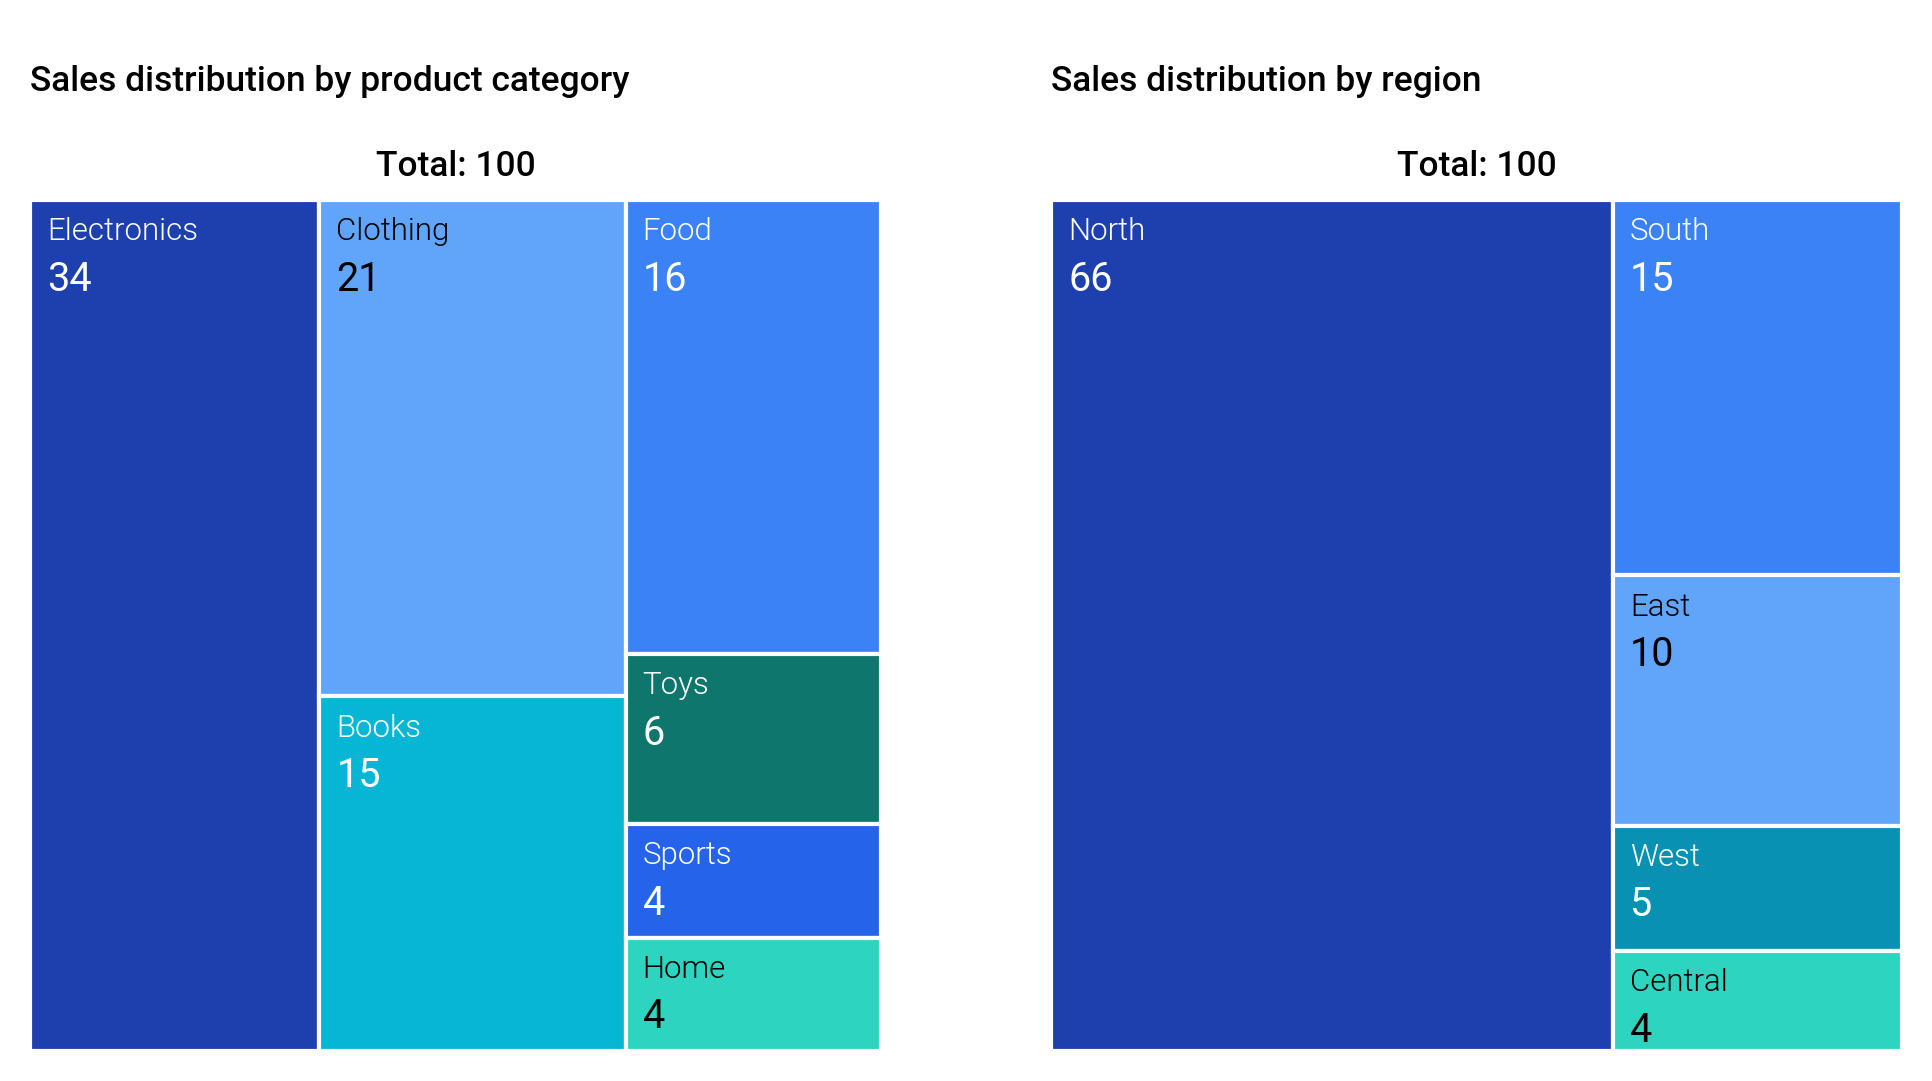

In [181]:
# Create figure with two subplots
# Each treemap area (0~1.0 x 0~1.0) should be square
# With two subplots side by side, width should be approximately 2x height
# Considering title space (ylim extends to 1.2), adjust accordingly
fig_width = 16.0  # cm (adjusted for square aspect ratio)
fig_height = 9.0  # cm (square ratio for each subplot)
fig, axes = plt.subplots(
    1, 2, figsize=(dm.cm2in(fig_width), dm.cm2in(fig_height)), dpi=300
)

# Draw product treemap (left)
draw_treemap(
    axes[0],
    product_columns,
    product_column_totals,
    product_total,
    "Sales distribution by product category",
)

# Draw region treemap (right)
draw_treemap(
    axes[1],
    region_columns,
    region_column_totals,
    region_total,
    "Sales distribution by region",
)

dm.simple_layout(fig)
plt.show()

Area proportionality verified. Max error: 0.00e+00
Area proportionality verified. Max error: 0.00e+00


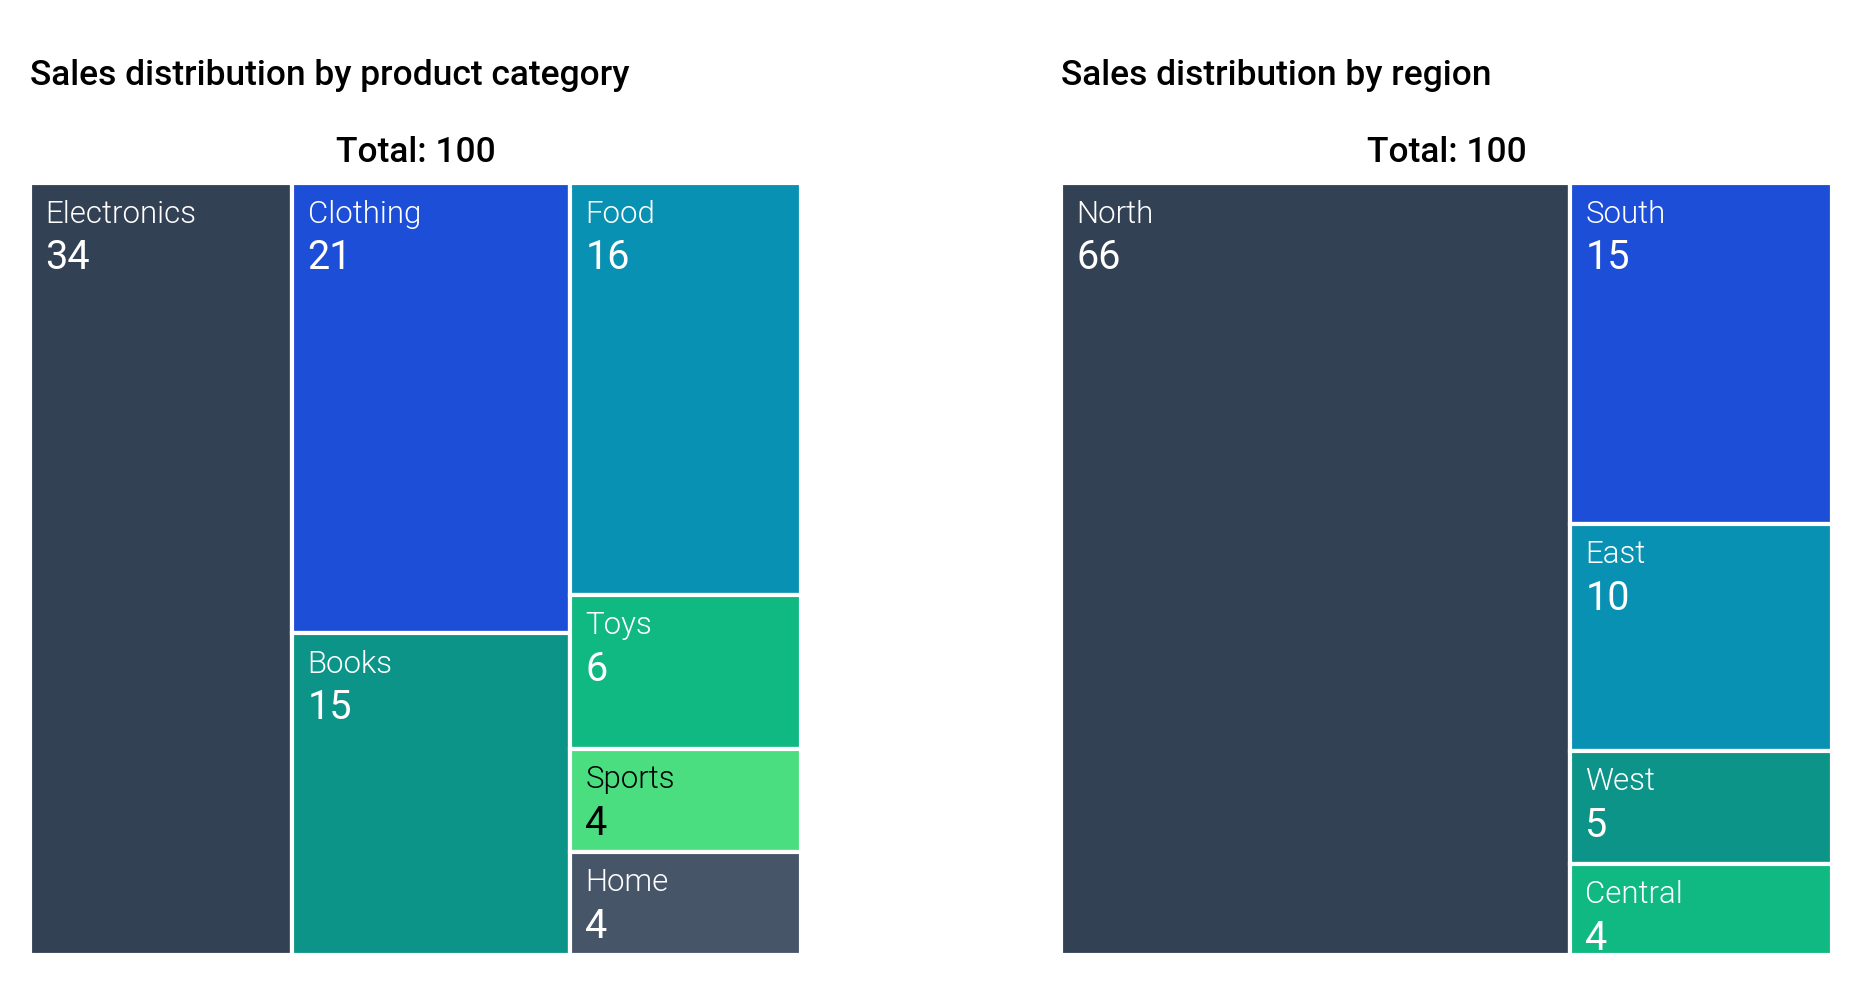

In [182]:
# Color Scheme 2: Ocean Depths
product_data_2 = [
    ("Electronics", 34, "tw.slate:700"),
    ("Clothing", 21, "tw.blue:700"),
    ("Food", 16, "tw.cyan:600"),
    ("Books", 15, "tw.teal:600"),
    ("Toys", 6, "tw.emerald:500"),
    ("Sports", 4, "tw.green:400"),
    ("Home", 4, "tw.slate:600"),
]

region_data_2 = [
    ("North", 66, "tw.slate:700"),
    ("South", 15, "tw.blue:700"),
    ("East", 10, "tw.cyan:600"),
    ("West", 5, "tw.teal:600"),
    ("Central", 4, "tw.emerald:500"),
]

product_columns_2 = [
    [product_data_2[0]],
    [product_data_2[1], product_data_2[3]],
    [product_data_2[2], product_data_2[4], product_data_2[5], product_data_2[6]],
]

region_columns_2 = [
    [region_data_2[0]],
    [region_data_2[1], region_data_2[2], region_data_2[3], region_data_2[4]],
]

product_column_totals_2 = [
    sum(value for _, value, _ in col) for col in product_columns_2
]
region_column_totals_2 = [sum(value for _, value, _ in col) for col in region_columns_2]
product_total_2 = sum(value for _, value, _ in product_data_2)
region_total_2 = sum(value for _, value, _ in region_data_2)

fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(16), dm.cm2in(8)), dpi=300)
draw_treemap(
    axes[0],
    product_columns_2,
    product_column_totals_2,
    product_total_2,
    "Sales distribution by product category",
)
draw_treemap(
    axes[1],
    region_columns_2,
    region_column_totals_2,
    region_total_2,
    "Sales distribution by region",
)
dm.simple_layout(fig)
plt.show()

Area proportionality verified. Max error: 0.00e+00
Area proportionality verified. Max error: 0.00e+00


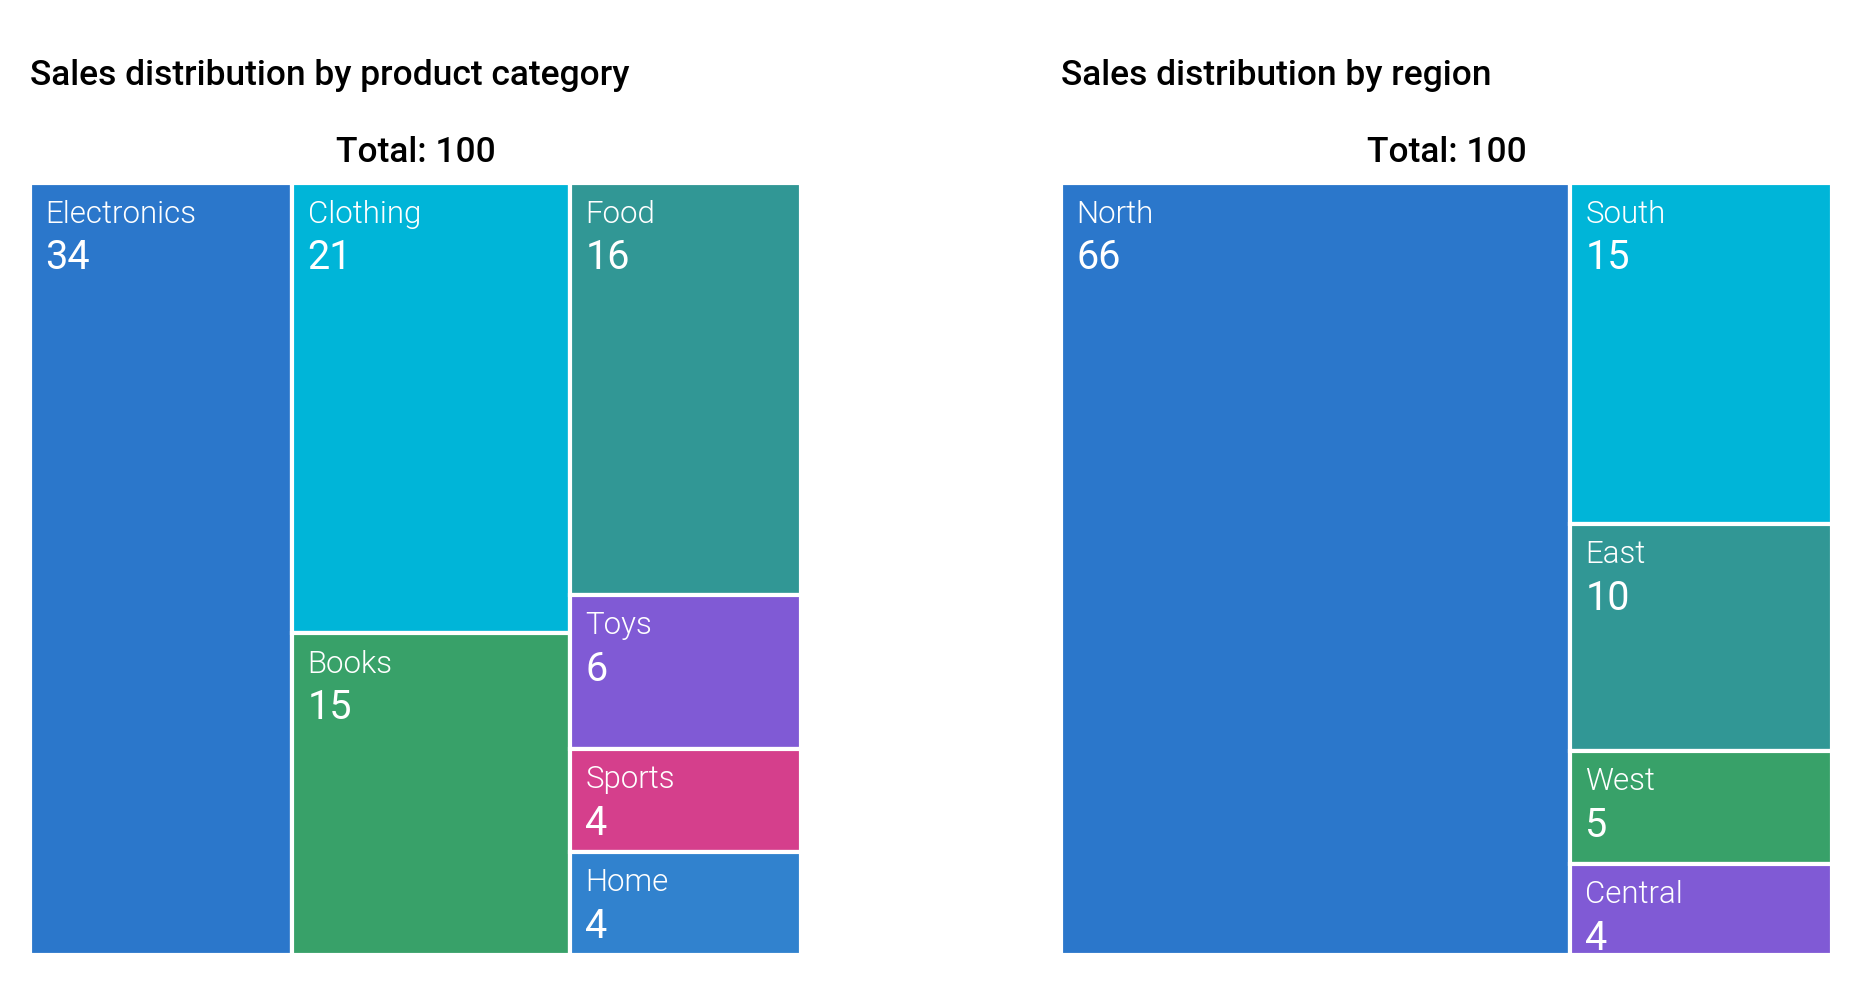

In [184]:
# Color Scheme 5: Chakra Soft
product_data_5 = [
    ("Electronics", 34, "chakra.blue:600"),
    ("Clothing", 21, "chakra.cyan:500"),
    ("Food", 16, "chakra.teal:500"),
    ("Books", 15, "chakra.green:500"),
    ("Toys", 6, "chakra.purple:500"),
    ("Sports", 4, "chakra.pink:500"),
    ("Home", 4, "chakra.blue:500"),
]

region_data_5 = [
    ("North", 66, "chakra.blue:600"),
    ("South", 15, "chakra.cyan:500"),
    ("East", 10, "chakra.teal:500"),
    ("West", 5, "chakra.green:500"),
    ("Central", 4, "chakra.purple:500"),
]

product_columns_5 = [
    [product_data_5[0]],
    [product_data_5[1], product_data_5[3]],
    [product_data_5[2], product_data_5[4], product_data_5[5], product_data_5[6]],
]

region_columns_5 = [
    [region_data_5[0]],
    [region_data_5[1], region_data_5[2], region_data_5[3], region_data_5[4]],
]

product_column_totals_5 = [
    sum(value for _, value, _ in col) for col in product_columns_5
]
region_column_totals_5 = [sum(value for _, value, _ in col) for col in region_columns_5]
product_total_5 = sum(value for _, value, _ in product_data_5)
region_total_5 = sum(value for _, value, _ in region_data_5)

fig, axes = plt.subplots(1, 2, figsize=(dm.cm2in(16), dm.cm2in(8)), dpi=300)
draw_treemap(
    axes[0],
    product_columns_5,
    product_column_totals_5,
    product_total_5,
    "Sales distribution by product category",
)
draw_treemap(
    axes[1],
    region_columns_5,
    region_column_totals_5,
    region_total_5,
    "Sales distribution by region",
)
dm.simple_layout(fig)
plt.show()